<a href="https://colab.research.google.com/github/matech96/DeepLearningAVizualisInformatikaban/blob/master/HF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pytorch-lightning
!pip install --upgrade tqdm==4.41.1

Requirement already up-to-date: tqdm==4.41.1 in /usr/local/lib/python3.6/dist-packages (4.41.1)


#Deep Learning Alkalmazása a Vizuális Informatikában 
##1. Házi feladat

**Fontos tudnivalók**

*   A házi feladatot önállóan kell elvégezni. Teljes megoldások máshonnan történő másolása nem elfogadható.
*   Ez a notebook egyben megoldás és dokumentáció. Az eredményeket értékeljétek ki, printelgessetek, ahhoz fűzzetek szépen megszerkesztett kommentárokat, stb.
*   Egy rész feladatot nem kell egyetlen kód blokkban megoldani. Sokkal szebb és struktúráltab lesz a munka, ha logikailag összetartozó egységekre bontjátok és azokat szépen egyesével magyarázzátok.
*   A házi feladat elkészítésére 3 hét áll rendelkezésetekre. Beadni az Edu portálon lehet. A határidő Március 12. 12:00.

### 1. Rész

Implementálj PyTorch-ban 2D konvolúciós réteget az NN, valamint a Functional modulok használata nélkül. A réteg konstruktorának a következő bemeneti paraméterei legyenek:


*   Kernel méret (n)
*   Bemeneti csatornaszám (inCH)
*   Kimeneti csatornaszám (oCH)

A rétegnek legyen forward függvénye, amelyben megkap egy [inCH x H x W] méretű tenzort, ahol H és W nem ismertek előre. A kimenete pedig legyen [oCH x H x W] (használj a kernel mérethez megfelelő paddinget).



In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


class Conv():
  def __init__(self, n, inCH, oCH):
    self.n = n
    self.inCH = inCH
    self.oCH = oCH
    self.W = torch.Tensor(np.random.randn(oCH,inCH,n,n)).requires_grad_(True)

  def parameters(self):
    yield self.W

  def forward(self, x):
    pad = self.n // 2
    x_ = torch.zeros(1,self.inCH,x.shape[2]+2*pad,x.shape[3]+2*pad).requires_grad_(False)
    if pad != 0:
      x_[0, :, pad:-pad, pad:-pad] = x
    else:
      x_ = x
    res = torch.zeros(1,self.oCH,x.shape[2],x.shape[3]).requires_grad_(False)
    for i in range(x_.shape[2] - self.n + 1):
      for j in range(x_.shape[3] - self.n + 1):
        res[0, :, i, j] = torch.addmv(torch.zeros(self.oCH), torch.reshape(self.W, (self.oCH, -1)), torch.reshape(x_[0, :, i:i+self.n, j:j+self.n], ((-1, ))))
    return res

  

Megnézem, hogy mindenova kerül-e érték.

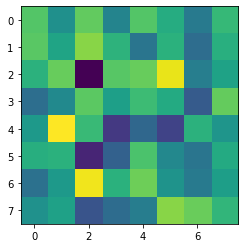

In [0]:
myconv = Conv(n = 5, inCH = 3, oCH = 1)

x = torch.Tensor(np.random.randn(1,3,8,8)).requires_grad_(False)
plt.imshow(myconv.forward(x).detach().numpy()[0,0,:,:])

###2. Rész

Amennyiben az implementáció elkészült, ellenőrizd az implementáció helyességét a PyTorch Conv2d modulja segítségével! (Tipp: Használj többfajta konfigurációt!)
https://pytorch.org/docs/stable/nn.html#conv2d

Egyenlővé teszem a kerneleket és vizuálisan összehasonlítom az eredményt.

In [0]:
n = 5
inCH = 3
oCH = 1
W = torch.Tensor(np.random.randn(oCH,inCH,n,n))
x = torch.Tensor(np.random.randn(1,3,8,8)).requires_grad_(False)

myconv = Conv(n = 5, inCH = 3, oCH = 1)
with torch.no_grad():
  myconv.W = nn.Parameter(W)
plt.subplot(1,2,1)
plt.imshow(myconv.forward(x).detach().numpy()[0,0,:,:])

refconv = nn.Conv2d(3, 1, (5, 5), padding=(2, 2), bias=False)
with torch.no_grad():
  refconv.weight = nn.Parameter(W)
plt.subplot(1,2,2)
plt.imshow(refconv(x).detach().numpy()[0,0,:,:])
plt.show()

AttributeError: ignored

Numerikus összehasonlítást végzek néhány jellemző konfigurációra.

In [0]:
for n in [1,3,5,7]:
  for inCH in [1,3,8,16]:
    for oCH in [1,3,8,16]:
      W = torch.Tensor(np.random.randn(oCH,inCH,n,n))
      x = torch.Tensor(np.random.randn(1,inCH,8,8)).requires_grad_(False)

      myconv = Conv(n, inCH, oCH)
      with torch.no_grad():
        myconv.W = nn.Parameter(W)
      myres = myconv.forward(x).detach().numpy()

      refconv = nn.Conv2d(inCH, oCH, (n, n), padding=(n//2, n//2), bias=False)
      with torch.no_grad():
        refconv.weight = nn.Parameter(W)
      refres = refconv(x).detach().numpy()

      assert(np.all((myres - refres) < 1e-4))

AttributeError: ignored

###3. Rész

Hozz létre egy egy bemeneti csatornás konvolúciós réteget, amelynek az egyes kimeneti csatornákhoz tartozó szűrőinek súlyait inicializáld véletlenszerűen. (A kimeneti csatornák száma legyen mondjuk 3.)

Ezt követően olvass be egy képet, szürkeárnyalatosítsd, és futtass le OpenCV segítségével 3 általad választott konvolúciós szűrőt!

Végezetül tanítsd be arra a létrehozott konvolúciós réteget, hogy az OpenCV-s szűréseket minél pontosabban reprodukálni tudja. Vizsgáld meg az eredményként kapott szűrőket! (Tipp: Az OpenCV-vel szűrt képeket használd referenciaként, mondjuk a négyzetes hiba költséggel. Több képet egy tömbbe összepakolni np.stack segítségével lehet.)

In [0]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms
import os
from PIL import ImageFilter

In [0]:
class GaussCifar(Dataset):
  def __init__(self):
    self.cifar = CIFAR10(os.getcwd() + '/cifar',download=True)

  def __getitem__(self, index):
    chFirst = lambda x: np.rollaxis(np.array(x, dtype=np.float32) / 255., 2, 0)
    return chFirst(self.cifar[index][0]), chFirst(self.cifar[index][0].filter(ImageFilter.Kernel((3, 3), 
          (-1, -1, -1, -1, 9, -1, -1, -1, -1), 1, 0)))
    
  def __len__(self):
    return len(self.cifar)

In [0]:
dl = DataLoader(GaussCifar(), batch_size=64)

Files already downloaded and verified


In [0]:
next(iter(dl))[1].dtype

torch.float32

In [0]:
import pytorch_lightning as pl
from torch.optim import Adam
class CoolCIFAR(pl.LightningModule):  
  def __init__(self, model):
    super(CoolCIFAR, self).__init__()
    self.model = model

  def parameters(self):
    return self.model.parameters()

  def forward(self, x):
    return self.model(x)

  def train_dataloader(self):
    return DataLoader(GaussCifar(), batch_size=64)

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)

  def training_step(self, batch, batch_idx):
    x, y = batch
    res = self.forward(x)
    loss = nn.MSELoss(res, y)

    # add logging
    logs = {'loss': loss}
    return {'loss': loss, 'log': logs}

In [0]:
from pytorch_lightning import Trainer

model = CoolCIFAR(nn.Conv2d(3, 3, (3, 3), padding=(3//2, 3//2), bias=False))
trainer = Trainer()
trainer.fit(model)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:root:
    Name    Type Params
0  model  Conv2d   81  


Epoch 1:   0%|          | 0/782 [00:00<?, ?batch/s]Files already downloaded and verified


RuntimeError: ignored